In [92]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import numpy as np
import os
from pathlib import Path
from PIL import Image

from sklearn.cluster import KMeans
from sklearn.decomposition import FastICA
from sklearn.metrics import silhouette_score

import torch
from torchvision import transforms
from torch.autograd import Variable

from tqdm import tqdm_notebook as tqdm

import sys
sys.path.insert(0, './model')

import model.classifier as classifier

In [81]:
base_data_folder = './data/data_clean'

# Define a global transformer to appropriately scale images and subsequently convert them to a Tensor.
img_size = 224
loader = transforms.Compose([
  transforms.Resize(img_size),
  transforms.CenterCrop(img_size),
  transforms.ToTensor(),
]) 

def load_image(filename):
    """
    Simple function to load and preprocess the image.

    1. Open the image.
    2. Scale/crop it and convert it to a float tensor.
    3. Convert it to a variable (all inputs to PyTorch models must be variables).
    4. Add another dimension to the start of the Tensor (b/c VGG expects a batch).
    5. Move the variable onto the GPU.
    """
    image = Image.open(filename).convert('RGB')
    image_tensor = loader(image).float()
    image_var = Variable(image_tensor).unsqueeze(0)
    return image_var

load_image('data/data_clean/train_data/Drew_Barrymore/aligned_vgg_bfff48d47d2ec61e678fa23f885df73d.jpg')

tensor([[[[0.7451, 0.7608, 0.7843,  ..., 0.8941, 0.8941, 0.8941],
          [0.7490, 0.7647, 0.7882,  ..., 0.8941, 0.8941, 0.8941],
          [0.7569, 0.7725, 0.7922,  ..., 0.8941, 0.8941, 0.8941],
          ...,
          [0.6392, 0.5843, 0.5451,  ..., 0.6118, 0.6431, 0.6706],
          [0.6627, 0.6000, 0.5490,  ..., 0.5569, 0.5843, 0.6157],
          [0.6784, 0.6078, 0.5529,  ..., 0.5294, 0.5529, 0.5843]],

         [[0.6235, 0.6392, 0.6627,  ..., 0.8706, 0.8706, 0.8706],
          [0.6275, 0.6431, 0.6667,  ..., 0.8706, 0.8706, 0.8706],
          [0.6353, 0.6510, 0.6706,  ..., 0.8706, 0.8706, 0.8706],
          ...,
          [0.4745, 0.4196, 0.3804,  ..., 0.4627, 0.4941, 0.5216],
          [0.4980, 0.4353, 0.3843,  ..., 0.4078, 0.4353, 0.4667],
          [0.5137, 0.4431, 0.3882,  ..., 0.3804, 0.4039, 0.4353]],

         [[0.4392, 0.4549, 0.4824,  ..., 0.8784, 0.8784, 0.8784],
          [0.4431, 0.4588, 0.4863,  ..., 0.8784, 0.8784, 0.8784],
          [0.4510, 0.4667, 0.4902,  ..., 0

In [82]:
# Load Training Data

train_data_folder = base_data_folder + '/train_data'

class_to_name = ['Aaron_Eckhart', 'Zac_Efron', 'Nicole_Richie', 'Christina_Ricci', 'Julia_Roberts', 'Drew_Barrymore', 'Brad_Pitt', 'Alyssa_Milano', 'Clive_Owen', 'Cristiano_Ronaldo']

#class_to_name = [os.path.basename(f.path) for f in os.scandir(train_data_folder) if f.is_dir()]

train_id_to_file = {i : path 
                    for (i,path) in enumerate(Path(train_data_folder).glob("*/*.jpg"))}

train_id_to_class = {i : class_to_name.index(os.path.basename(os.path.dirname(str(path))))
                     for (i,path) in enumerate(Path(train_data_folder).glob("*/*.jpg"))}

train_ids = list(train_id_to_file.keys())

# Load Validation Data

val_data_folder = base_data_folder + '/eval_data'

val_id_to_file = {i : path 
                    for (i,path) in enumerate(Path(val_data_folder).glob("*/*.jpg"))}

val_id_to_class = {i : class_to_name.index(os.path.basename(os.path.dirname(str(path))))
                     for (i,path) in enumerate(Path(val_data_folder).glob("*/*.jpg"))}

val_ids = list(val_id_to_file.keys())


print("Classes:")
print(class_to_name)

print("\nTraining Set Size: %s" % len(train_ids))
print("\nValidation Set Size: %s" % len(val_ids))

print("\nSample Images:")
print(train_id_to_file[len(train_ids)-1])
print(class_to_name[train_id_to_class[len(train_ids)-1]])

load_image(train_id_to_file[len(train_ids)-1])

print(val_id_to_file[0])
print(class_to_name[val_id_to_class[0]])

load_image(val_id_to_file[0])

Classes:
['Aaron_Eckhart', 'Zac_Efron', 'Nicole_Richie', 'Christina_Ricci', 'Julia_Roberts', 'Drew_Barrymore', 'Brad_Pitt', 'Alyssa_Milano', 'Clive_Owen', 'Cristiano_Ronaldo']

Training Set Size: 1368

Validation Set Size: 100

Sample Images:
data/data_clean/train_data/Drew_Barrymore/aligned_vgg_bfff48d47d2ec61e678fa23f885df73d.jpg
Drew_Barrymore
data/data_clean/eval_data/Zac_Efron/aligned_vgg_0c5e844bc8df7d4742c0a6f790a7e6f1 4.46.24 PM.jpg
Zac_Efron


tensor([[[[0.4353, 0.4431, 0.4353,  ..., 0.0275, 0.0314, 0.0353],
          [0.4314, 0.4392, 0.4353,  ..., 0.0314, 0.0392, 0.0431],
          [0.4275, 0.4392, 0.4392,  ..., 0.0392, 0.0471, 0.0510],
          ...,
          [0.0431, 0.0471, 0.0510,  ..., 0.0157, 0.0157, 0.0157],
          [0.0314, 0.0353, 0.0392,  ..., 0.0157, 0.0157, 0.0157],
          [0.0275, 0.0314, 0.0353,  ..., 0.0157, 0.0157, 0.0157]],

         [[0.4118, 0.4196, 0.4118,  ..., 0.0275, 0.0314, 0.0353],
          [0.4078, 0.4157, 0.4118,  ..., 0.0314, 0.0392, 0.0431],
          [0.4039, 0.4157, 0.4157,  ..., 0.0392, 0.0471, 0.0510],
          ...,
          [0.0510, 0.0549, 0.0549,  ..., 0.0157, 0.0157, 0.0157],
          [0.0510, 0.0549, 0.0549,  ..., 0.0157, 0.0157, 0.0157],
          [0.0471, 0.0510, 0.0549,  ..., 0.0157, 0.0157, 0.0157]],

         [[0.2863, 0.2941, 0.2863,  ..., 0.0353, 0.0392, 0.0431],
          [0.2824, 0.2902, 0.2863,  ..., 0.0392, 0.0471, 0.0510],
          [0.2784, 0.2902, 0.2902,  ..., 0

In [83]:
# Create the model

model = classifier.FaceClassifier()

if torch.cuda.is_available():
    model = model.cuda()
    
print(model)

FaceClassifier(
  (model): Vgg_face_dag(
    (conv1_1): Conv2d(3, 64, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
    (relu1_1): ReLU(inplace)
    (conv1_2): Conv2d(64, 64, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
    (relu1_2): ReLU(inplace)
    (pool1): MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
    (conv2_1): Conv2d(64, 128, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
    (relu2_1): ReLU(inplace)
    (conv2_2): Conv2d(128, 128, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
    (relu2_2): ReLU(inplace)
    (pool2): MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
    (conv3_1): Conv2d(128, 256, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
    (relu3_1): ReLU(inplace)
    (conv3_2): Conv2d(256, 256, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
    (relu3_2): ReLU(inplace)
    (conv3_3): Conv2d(256, 256, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
    (relu3_3):

In [84]:
# Load Training Images and Labels

print('Loading training images...')

#train_ids = train_ids[:50]

images = Variable(torch.zeros((len(train_ids),3,img_size,img_size)))
labels = Variable(torch.zeros(len(train_ids)).long())

for i,train_id in enumerate(tqdm(train_ids)):
    # Prepare the image tensors
    images[i] = load_image(train_id_to_file[train_id])
    
    # Prepare the labels
    labels[i] = train_id_to_class[train_id]

# Load Validation Images and Labels

print('Loading validation images...')

val_images = Variable(torch.zeros((len(val_ids),3,img_size,img_size)))
val_labels = Variable(torch.zeros(len(val_ids)).long())

for i,val_id in enumerate(tqdm(val_ids)):
    # Prepare the image tensors
    val_images[i] = load_image(val_id_to_file[val_id])
    
    # Prepare the labels
    val_labels[i] = val_id_to_class[val_id]

X = images
y = labels

X_val = val_images
y_val = val_labels

Loading training images...


Loading validation images...


In [85]:
# # Fine-tune and save the model

# print('Fine-tuning the model...')

# model.tune(X, y, X_val, y_val)

# print('Saving the model...')

# filename = 'model/tuned_classifier.pth'
# torch.save(model.state_dict(), filename)

# print('Model saved as %s' % filename)

In [86]:
# Load the model

model = classifier.FaceClassifier()

if torch.cuda.is_available():
    model = model.cuda()
    
model.load_state_dict(torch.load('model/tuned_classifier.pth', map_location='cpu'))

model = model.eval()    

print(model)

FaceClassifier(
  (model): Vgg_face_dag(
    (conv1_1): Conv2d(3, 64, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
    (relu1_1): ReLU(inplace)
    (conv1_2): Conv2d(64, 64, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
    (relu1_2): ReLU(inplace)
    (pool1): MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
    (conv2_1): Conv2d(64, 128, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
    (relu2_1): ReLU(inplace)
    (conv2_2): Conv2d(128, 128, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
    (relu2_2): ReLU(inplace)
    (pool2): MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
    (conv3_1): Conv2d(128, 256, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
    (relu3_1): ReLU(inplace)
    (conv3_2): Conv2d(256, 256, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
    (relu3_2): ReLU(inplace)
    (conv3_3): Conv2d(256, 256, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
    (relu3_3):

In [87]:
# Define a function for clustering activations

def cluster_activations(activations, n_dims=10):
    """
    Cluster the activations after reducing dimensions to n_dims
    """
    
    transformer = FastICA(n_components=n_dims, random_state=10)
    activations_transformed = transformer.fit_transform(activations)
    
    cluster_labels = KMeans(n_clusters=2, random_state=10).fit_predict(activations_transformed)
    
    return activations_transformed, cluster_labels

# Define a function for segmenting the dataset by class

def segment_by_class(X, y, class_id):
    """
    Returns only the items from X and y that are in the given class_id
    """
    
    n = np.sum((y == class_id).numpy())
    
    X_segment = Variable(torch.zeros(n,3,img_size,img_size))
    y_segment = Variable(torch.zeros(n).long())
    
    index = 0
    
    for i, label in enumerate(y):
        if label == class_id:
            X_segment[index] = X[i]
            y_segment[index] = y[i]
            index += 1
        
    return X_segment, y_segment

In [88]:
# Activation clustering

segmented_X = []
segmented_y = []

activations = []

activations_transformed = []
clusters_labels = []

silhouette_scores = []

for class_id in range(len(class_to_name)):
    seg_X, seg_y = segment_by_class(X,y,class_id)
    
    
    segmented_X.append(seg_X)
    segmented_y.append(seg_y)
    
    acts = model.get_activations(seg_X)
    activations.append(acts)
    acts_trans, labels = cluster_activations(acts)
    
    activations_transformed.append(acts_trans)
    clusters_labels.append(labels)
    
    print(acts_trans.shape)
    print(labels)
    sil_score = silhouette_score(acts_trans, labels)
    silhouette_scores.append(sil_score)
    print(silhouette_scores)

print(silhouette_scores)


(208, 10)
[0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


(171, 10)
[1 0 1 0 0 1 1 0 1 1 0 0 0 0 0 0 1 1 1 0 0 0 0 1 1 0 1 1 1 1 1 0 0 0 0 0 1
 1 0 0 0 0 1 0 0 1 0 1 1 0 0 0 1 1 1 1 1 1 0 0 1 1 0 0 0 0 0 0 1 0 0 1 0 1
 1 0 0 1 0 0 0 0 1 0 1 1 1 1 0 1 0 0 0 0 0 0 1 1 1 1 1 1 0 1 1 1 1 1 0 0 1
 1 0 0 0 1 1 0 1 0 1 0 1 0 0 0 1 1 0 1 1 0 0 1 1 0 1 0 0 1 0 0 0 1 0 0 1 1
 1 1 0 1 1 1 0 1 0 0 1 1 1 1 0 0 1 0 1 1 1 0 0]


/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/fastica_.py:121: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


(103, 10)
[1 0 0 0 0 0 1 1 1 0 1 0 1 1 1 1 1 1 1 0 1 0 1 1 0 0 1 1 1 1 1 0 0 1 1 1 0
 0 0 0 0 1 1 0 1 1 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 0 1 0 1 0 1 1 0 1 1 1 1 0
 1 1 1 0 0 0 0 1 0 1 1 1 1 0 1 1 1 0 1 1 1 0 1 1 0 0 1 0 1]


(91, 10)
[0 0 1 1 1 1 1 0 0 0 0 0 1 0 1 1 0 0 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 0 0 0 0
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 0 1 1 0 0
 1 0 1 0 0 0 1 1 1 1 1 1 1 0 1 1 1]


/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/fastica_.py:121: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/fastica_.py:121: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


(117, 10)
[0 0 0 0 0 1 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 1 1 0 0 0 0 1 1 0 0 1 0 0 1 1 1
 0 0 1 1 0 0 0 0 1 1 0 0 0 1 0 1 1 0 0 1 0 0 1 1 1 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 1 0 0 1 0 0 1 0 1 0 0 0 0 1 0 0 1 0 0 0 1 0 0 1 1 1 0 0 0 1 0 0 1
 1 0 1 1 1 0]


(120, 10)
[1 0 0 1 0 1 0 1 1 0 1 0 1 1 0 1 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 1 0 1 0 0 0
 0 1 0 0 0 1 0 1 0 0 0 1 0 0 0 0 1 1 0 1 0 1 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0
 1 0 0 1 0 0 0 1 0 1 0 0 0 0 1 0 1 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 1
 0 0 0 0 1 0 1 0 1]


/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/fastica_.py:121: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


(219, 10)
[0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 1 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0]


(111, 10)
[0 0 1 1 0 1 1 1 1 0 1 0 0 1 1 0 1 0 1 1 0 0 1 0 0 0 0 1 1 0 0 1 1 1 0 0 1
 1 0 1 1 1 0 1 0 0 0 1 1 0 0 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 0 1 0 0 1 1 0 0
 1 1 0 1 1 0 1 0 1 1 0 1 1 1 1 0 0 1 0 1 1 0 0 1 0 1 0 0 0 0 1 0 1 1 0 1 0]


/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/fastica_.py:121: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


(103, 10)
[1 0 1 1 1 1 0 0 0 1 0 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 0
 1 1 1 0 1 0 1 1 0 1 0 1 1 0 0 1 1 1 0 1 1 1 1 0 0 1 1 1 1 1 1 0 1 1 1 1 0
 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 0 1 1 1 1 1 0 1 1 1 0 1 1]


(125, 10)
[0 1 0 1 1 1 1 0 1 1 1 0 0 0 0 1 0 0 0 1 1 1 1 0 1 0 1 1 0 1 0 0 1 0 1 0 0
 1 1 1 1 1 1 0 1 1 1 0 0 1 0 1 0 0 1 1 1 0 1 1 0 0 1 1 0 1 0 1 0 0 1 1 1 1
 0 1 0 1 1 0 0 1 0 0 1 1 1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 1 1 0 1 0 1 1 1
 1 0 1 1 0 1 1 0 1 1 0 1 1 0]
[0.44768741030197273, 0.07752015892591928, 0.08316435015591665, 0.08143435162497864, 0.07849253556671038, 0.09072413930901642, 0.12935858253284307, 0.07295104887331061, 0.12349067469727336, 0.09021533329964837]


- Use activation clustering on evaluation set
- silhouette_score to see if poisonous examples exist
- take smaller cluster as suspected poisonous examples

In [ ]:
# Save predictions for unlabeled test set

# Concatenate test examples with training set

# Get activations, cluster activations

# Compute silouette score

# Score > 0.12 => poisoned

# Smaller cluster 

# Visualization (first 2 or 3 components of activations)


In [ ]:
# Pre-cluster training set

# Save predictions for unlabeled test set, get activations

# Dimensionality reduction and KNN from predictions to training clusters





# Smaller cluster 

# Visualization (first 2 or 3 components of activations)


In [153]:
def generate_activations_plot(clean_activations, poison_activations, dims=3, title=None):
    """
    Generates a scatterplot of the activations
    """
    
    if dims == 2:        
        if clean_activations is not None:
            plt.scatter(clean_activations[:,0], clean_activations[:,1], c='b', marker='o', label='Honest')

        if poison_activations is not None:
            plt.scatter(poison_activations[:,0], poison_activations[:,1], c='r', marker='o', label='Malicious')

        plt.xlabel('PC1')
        plt.ylabel('PC2')
        if title is not None:
            plt.title(title)
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
        plt.tight_layout()

        plt.show()
        return None
    elif dims == 3:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

        if clean_activations is not None:
            ax.scatter(clean_activations[:,0], clean_activations[:,1], clean_activations[:,2], c='b', marker='o', label='Honest')

        if poison_activations is not None:
            ax.scatter(poison_activations[:,0], poison_activations[:,1], poison_activations[:,2], c='r', marker='o', label='Malicious')

        ax.set_xlabel('PC1')
        ax.set_ylabel('PC2')
        ax.set_zlabel('PC3')
        if title is not None:
                plt.title(title)
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
        plt.tight_layout()

        plt.show()

        return None
    else:
        return None

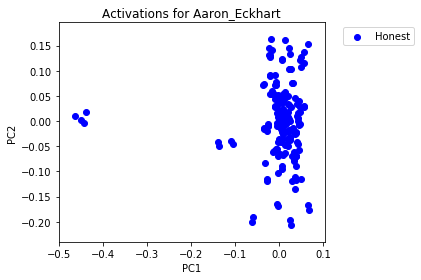

In [151]:
generate_activations_plot(activations_transformed[0],None,dims=2,title="Activations for Aaron_Eckhart")

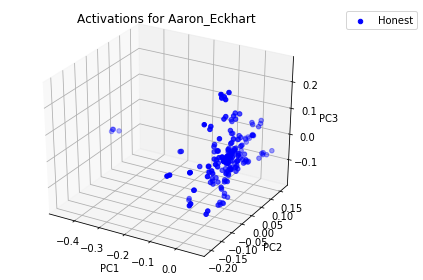

In [152]:
generate_activations_plot(activations_transformed[0],None,dims=3,title="Activations for Aaron_Eckhart")